In [18]:
import torch
import numpy as np
import awkward as ak
lf = torch.load("AToGG_pickles_500k_resnet/detfeat.pickle")
lf2 = torch.load("AToGG_pickles_500k_resnet/localfeat.pickle")

In [19]:
lf_ar = [ np.array(i['x']) for i in lf ]
hitsEta = [ np.array(i['x'])[:,0] for i in lf2 ]

In [20]:
hitsiEta = [ i[:,0] for i in lf_ar ]
hitsiPhi = [ i[:,1] for i in lf_ar ]
hitsEn = [ i[:,2] for i in lf_ar ]

In [21]:
seedidx = [np.argmax(i) for i in hitsEn]
relEta = [ i - hitsiEta[event][seedidx[event]] for event,i in enumerate(hitsiEta) ]
relPhi = [ i - hitsiPhi[event][seedidx[event]] for event,i in enumerate(hitsiPhi) ]

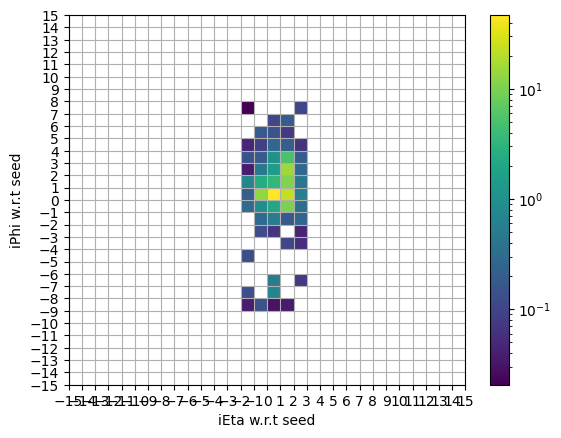

In [22]:
event = 124
import matplotlib.pyplot as plt
x_range = (-15,15)
y_range = (-15,15)

ax = plt.axes()
x_bins = np.arange(x_range[0], x_range[1] + 1, 1)  # Bin edges for x-axis
y_bins = np.arange(y_range[0], y_range[1] + 1, 1) 
ax.set_xticks(x_bins)
ax.set_yticks(y_bins)
plt.hist2d(relEta[event].round(),relPhi[event].round(),weights=hitsEn[event],bins=[x_bins,y_bins],norm='log')
plt.xlabel("iEta w.r.t seed")
plt.ylabel("iPhi w.r.t seed")
#plt.xlim(-6,6)

plt.grid()
plt.colorbar()

In [29]:
dim = 24
imgf = []
length = len(hitsEn)
for event in range(length):
    image = np.zeros((2,dim,dim))
    etaidx = np.clip(int(dim/2) + relEta[event].round().astype(int),0,dim-1)
    phiidx = np.clip(int(dim/2) - relPhi[event].round().astype(int),0,dim-1)
    
    theta = 2*np.arctan(np.exp(-1*hitsEta[event]))
    image[ 0,phiidx,etaidx ] = hitsEn[event]*np.sin(theta)
    image[ 1,phiidx,etaidx ] = hitsEn[event]*np.abs(np.cos(theta))
    imgf.append(image)
len(imgf)

359525

In [30]:
from torch_geometric.data import Data
import torch
data = [
        Data(x=torch.from_numpy(ak.to_numpy(Pho).astype(np.float32))) for Pho in imgf
    ]
torch.save(data, open('cartfeat.pickle','wb'), pickle_protocol=4)

(array([[2247.,  157.,    0., ...,    0.,    0.,    0.],
        [   0., 2419., 1547., ...,    0.,    0.,    0.],
        [   0.,    0., 2191., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0., 4239.],
        [   0.,    0.,    0., ...,    0.,    0., 4097.],
        [   0.,    0.,    0., ...,    0.,    0., 2486.]]),
 array([-0.54713613, -0.50525068, -0.46336524, -0.42147979, -0.37959434,
        -0.3377089 , -0.29582345, -0.253938  , -0.21205256, -0.17016711,
        -0.12828166, -0.08639622, -0.04451077, -0.00262533,  0.03926012,
         0.08114557,  0.12303101,  0.16491646,  0.20680191,  0.24868735,
         0.2905728 ,  0.33245824,  0.37434369,  0.41622914,  0.45811458,
         0.50000003,  0.54188548,  0.58377092,  0.62565637,  0.66754182,
         0.70942726,  0.75131271,  0.79319815,  0.8350836 ,  0.87696905,
         0.91885449,  0.96073994,  1.00262539,  1.04451083,  1.08639628,
         1.12828172,  1.17016717,  1.21205262,  1.25393806,

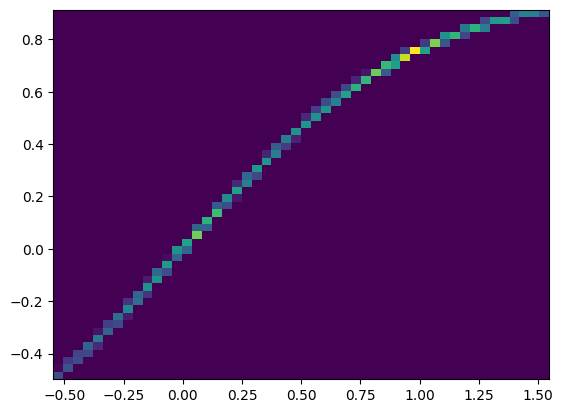

In [ ]:
eta = []
theta = []
for i in range(0,10000):
    eta.extend(hitsEta[i])    
    theta.extend(np.cos(2*np.arctan(np.exp(-1*hitsEta[i]))))    
plt.hist2d(eta,theta,bins=50)


In [32]:
split = 0.8
print(length)
import pickle
train_idx = np.random.choice(length, int(split * length + 0.5), replace=False)

mask = np.ones(length, dtype=bool)
mask[train_idx] = False
valid_idx = mask.nonzero()[0]
folder = "AToGG_pickles_500k_resnet"
with open("%s/all_valididx.pickle" % folder, "wb") as f:
    pickle.dump(valid_idx, f)

with open("%s/all_trainidx.pickle" % folder, "wb") as f:
    pickle.dump(train_idx, f)
with open("%s/all_valididx.pickle" % folder, "wb") as f:
    pickle.dump(valid_idx, f)

359525


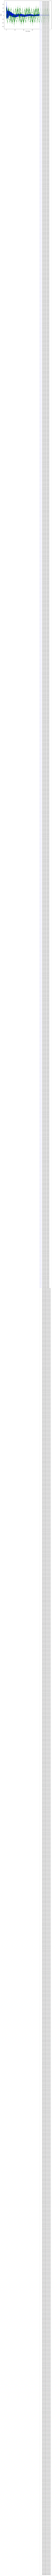

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the true process dynamics
def true_process_model(x, t):
    return 0.5 * x + 25 * x / (1 + x**2) + 8 * np.cos(1.2 * t)

# Define the observation model
def observation_model(x, noise_std):
    return x + np.random.normal(0, noise_std)

# Define the branching process for particle evolution
def branching_process(x, branching_prob):
    # Each particle independently branches with a certain probability
    mask = np.random.rand(len(x)) < branching_prob
    x[mask] = x[mask] + np.random.normal(0, 5, np.sum(mask))
    return x

# Initialize parameters
num_particles = 1000
initial_particles = np.random.uniform(-10, 10, size=num_particles)
particle_weights = np.ones(num_particles) / num_particles

# Simulation parameters
num_time_steps = 100
observation_noise_std = 5
branching_prob = 0.1  # Probability of branching at each time step

# Arrays to store results
estimated_states = np.zeros((num_time_steps, num_particles))
resampled_particles = np.zeros((num_time_steps, num_particles))

# Particle filter loop
for t in range(num_time_steps):
    # Predict step
    predicted_particles = true_process_model(initial_particles, t)

    # Branching step
    initial_particles = branching_process(predicted_particles, branching_prob)

    # Update step
    observed_data = observation_model(initial_particles, observation_noise_std)
    particle_weights *= np.exp(-0.5 * ((observed_data - initial_particles) / observation_noise_std)**2)
    particle_weights /= np.sum(particle_weights)

    # Resampling step
    indices = np.random.choice(np.arange(num_particles), size=num_particles, replace=True, p=particle_weights)
    resampled_particles[t, :] = initial_particles[indices]
    initial_particles = resampled_particles[t, :]

    # Store estimated states
    estimated_states[t, :] = np.mean(resampled_particles[:t + 1, :], axis=0)

# Plotting
time_points = np.arange(num_time_steps)
plt.figure(figsize=(10, 6))
plt.plot(time_points, estimated_states, label='Estimated States', color='blue', alpha=0.5)
plt.plot(time_points, resampled_particles, '.', label='Resampled Particles', color='green', alpha=0.1)
plt.xlabel('Time Steps')
plt.ylabel('State')
plt.legend()
plt.show()
